<a href="https://colab.research.google.com/github/oradbarel/Fall-Prevention/blob/main/Fall_Prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall Pervention - Data Analysis Document Review

### Table of Content:
1. [Background](#1)
2. [Creating a Dataset](#2)
3. [Choosing a Model](#3)
> 3.a. [Decision Tree](#3.a) <br>
> 3.b. [Transformer Neural Network](#3.b) <br>
> 3.c. [Recurrent Neural Network](#3.c) <br>
> 3.d. [Conclusion](#3.d) <br>
4. [Building the Model (RNN)](#4)




<a name="1"></a> 
### 1. Background:

TODO

<a name="2"></a> 
### 2. Creating a Dataset:

TODO

<a name="3"></a> 
### 3. Choosing a Model:

In order to predict the patient's current status (back lying, side lying, getting up), we should create a prediction model (Using Machine Learning or Deep Learning) which will use our dataset.<br>
Best suited models to our prediction problem:

<a name="3.a"></a> 
### 3.a. Decision Tree:
Background <br>
####Pros:
- Explainable - DT will make decisions that depends on the discreet values of our sensors.
- Fast decision making - Real time predictions at O(d) when d is the deepest node of the tree (WC)

####Cons:
- Work on only 1 sample to predict - The DT can only look at 1 sample (as set of features) at once
-  Might not be accurate - DT model predicts by horizontal and vertical separations.

<a name="3.b"></a> 
### 3.b. Transformer Neural Network:
Background <br>
####Pros:
- High expexted prediction rate - more complex, non-linear function can be learned
- Take into account the relations between the features - We can weight the relationships between different sensors inputs for more accurate "features"

####Cons:
- Work on only 1 sample to predict - can only look at 1 sample (as set of features) at once
- Zero to no explainability - Known problem of DNNs
- Harder to train - Require rich dataset and heavy compute equipment

<a name="3.c"></a> 
### 3.c.  Recurrent Neural Network:
Background <br>
####Pros:
- High expexted prediction rate - more complex, non-linear function can be learned
- Works on data streams - Use series of time adjacent samples in order to make the predictions

####Cons:
- Zero to no explainability - Known problem of DNNs
- Harder to train - Require rich dataset and heavy compute equipment

<a name="3.d"></a> 
### 3.d.  Conclusion:
RNN (Recurrent Neural Network) seems to be the Ideal model the our prediction problem, as it's the only option that let us use data streams.

<a name="4"></a> 
### 4.  Building the Model (RNN):
High level flow chart of the RNN:

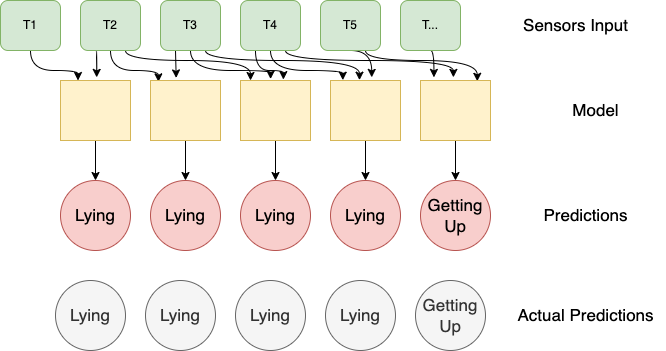

#### Importing the libraries
We'll use Matplotlib for our charts, Numpy, Pandas, Seaborn for the data and calculations, and Tensorflor for the Neural Network.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#### Dataset Simulation
To Simulate the sensors data, we can use the data set from https://physionet.org/content/pmd/1.0.0/.

Each sample from this dataset discribes a value of pressure sensor, from 32x64 sensors matrix, thats lying under a patient bed.

In [ ]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset 

--2022-11-09 08:32:21--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’

a-pressure-map-data 100%[===================>] 102.34M  2.09MB/s    in 44s     

2022-11-09 08:33:05 (2.33 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip’ saved [107315828/107315828]



Libraries for are simulation:

In [ ]:
import torch
import os
from torchvision import transforms
import copy
from time import sleep as zzz
from IPython.display import clear_output

Creating the (simulated) dataset:

In [91]:
data_path = './dataset/experiment-i/'

"""
Classification order of the sample files:
0 - back lynig, 1 - right lying, 2 - left lying
"""
pos_order = [0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0]

data = {}

# For each Patient dir
for dir in os.listdir(data_path):
  if os.path.isfile(os.path.join(data_path, dir)):
    continue

  new_data, labels = None, None

  # For each data file
  for file in os.listdir(os.path.join(data_path, dir)):
    with open(os.path.join(data_path, dir, file), 'r') as f:
      for line in f.read().splitlines():
        raw_data = np.fromstring(line, dtype=float, sep='\t')
        file_data = np.round((raw_data*255)/1000).astype(np.uint8)
        Normalize = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor()])
        file_data = Normalize(file_data.reshape(64,32))
        file_data = file_data.view(1, 64, 32)
        file_label = np.array([pos_order[int(file[:-4])]])

        if new_data is None:
          new_data = file_data
        else:
          new_data = np.concatenate((new_data, file_data), axis=0)
          
        if labels is None:
          labels = file_label
        else:
          labels = np.concatenate((labels, file_label), axis=0)

  data[dir] = (torch.from_numpy(new_data), torch.from_numpy(labels))

Extracting patients weight:

In [92]:
file_path = os.path.join(data_path, 'subject-info-i.csv')
weights = pd.read_csv(file_path, encoding="utf-16")

Choosing the sensors layout we will use in our dataset:

Text(0.5, 1.0, "Sensors that we'll use (in yellow)")

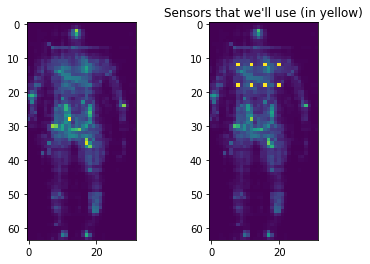

In [93]:
sensors = [(12,8), (12,12), (12,16), (12,20), (18,8), (18,12), (18,16), (18,20)]

def paint_sensors(sample):
  for sensor in sensors:
    sample[sensor[0]][sensor[1]] = 0.5

sample = copy.deepcopy(data['S2'][0].numpy()[450])
paint_sensors(sample)

f, pl = plt.subplots(1, 2)
pl[0].imshow(data['S2'][0].numpy()[450])
pl[1].imshow(sample)

plt.title("Sensors that we'll use (in yellow)")

Code for visualise the patient's position over the time:

In [ ]:
"""
for i in data['S2'][0].numpy():
  plt.imshow(i)
  plt.show()
  clear_output(wait=True)
"""

"\nfor i in data['S2'][0].numpy():\n  plt.imshow(i)\n  plt.show()\n  clear_output(wait=True)\n"

#### Creating the actual simulated dataset:
Each sample in the dataset will consist:
- sensors[0-7]
- patient weight
- binary label (0 - back lynig, 1 - right side lying, 2 - left side lying)

In [94]:
df_labels = ["FS0", "FS1", "FS2", "FS3", "FS4", "FS5", "FS6", "FS7", "Weight", "Pos"]
dataset = []

for patient in data.keys():
  patient_weight = weights['Weight/kg'][int(patient[1:]) - 1]
  sample = data[patient][0].numpy()
  for i, s in enumerate(sample):
    to_add = [s[sensor[0]][sensor[1]] for sensor in sensors]
    to_add.append(patient_weight)
    to_add.append(data[patient][1][i].item())
    dataset.append(to_add)

df = pd.DataFrame(dataset, columns = df_labels)

Dataset sample - Sanity check:

We can see that the for each row of our force sensors, we get values that get bigger (left to right) because our patient in this case is lying on the right side of it's bed.

,FS0,FS1,FS2,FS3,FS4,FS5,FS6,FS7,Weight,Pos
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66,1
1,0.298039,0.533333,0.000000,0.019608,0.788235,0.039216,0.058824,0.274510,66,1
2,0.015686,0.027451,0.066667,0.070588,0.031373,0.015686,0.047059,0.039216,66,1
3,0.015686,0.027451,0.066667,0.070588,0.031373,0.015686,0.047059,0.043137,66,1
4,0.015686,0.027451,0.066667,0.074510,0.031373,0.011765,0.047059,0.043137,66,1


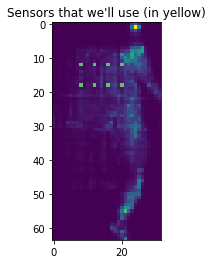

In [95]:
sample = copy.deepcopy(data[list(data.keys())[0]][0].numpy()[5])
paint_sensors(sample)
plt.imshow(sample)
plt.title("Sensors that we'll use (in yellow)")
df.head()

Let's explore our data a little bit further:

We can clearly see that when the patient is lying on is back, our patient's weight is devided between the force sensors equally (more or less).

Also, When the patient is lying on his/hers side, we can see that the force sensors on coresponding side are also report bigger number on average.

(When the patient is on the left, we see higer numbers on FS0, FS4<br>
and when the patient is on the right, we see higer numbers on FS3, FS7)

Text(0.5, 1.0, 'Sensors values when left lying')

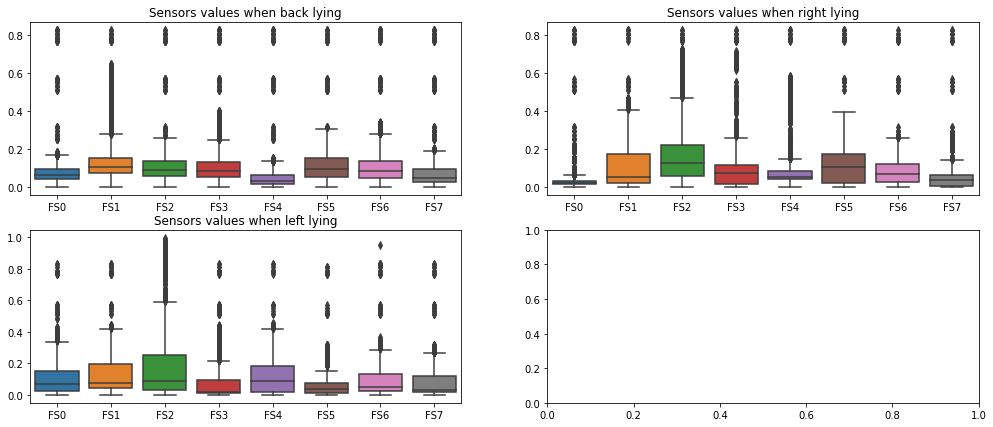

In [115]:
f, pl = plt.subplots(2, 2, figsize=(17, 7))

tmpdf0 = df[df.Pos == 0]
tmpdf1 = df[df.Pos == 1]
tmpdf2 = df[df.Pos == 2]

sns.boxplot(ax = pl[0][0], data=tmpdf0.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])
sns.boxplot(ax = pl[0][1], data=tmpdf1.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])
sns.boxplot(ax = pl[1][0], data=tmpdf2.loc[:,['FS0', 'FS1', 'FS2', 'FS3', 'FS4', 'FS5', 'FS6', 'FS7']])

pl[0][0].set_title("Sensors values when back lying")
pl[0][1].set_title("Sensors values when right lying")
pl[1][0].set_title("Sensors values when left lying")

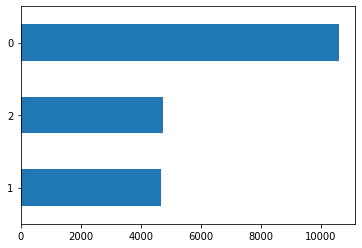

In [108]:
df.Pos.value_counts().sort_values().plot(kind = 'barh')